# Tutorial: Cepheid Period-Luminosity Data

In which we will... look at some cepheid period-luminosity data.

**Note:** This tutorial counts for nothing and does not need to be turned in. It simply serves as an introduction to the data set used in two later tutorials. There are a couple of `TBC`s here that will be useful for those tutorials - either you will just copy your solution over, or your solution here will be the basis, with some modification, for something later.

## Background 

Cepheids are stars whose brightness oscillates with a stable period, the logarithm of which appears to be strongly correlated with their mean absolute magnitude. Traditionally, these stars form part of the "distance ladder" establishing the relationship between cosmological redshift and distance, i.e. the Hubble expansion rate. The absolute luminosity for a given period is measured in our Galaxy, or one very nearby, where the distance can be determined by geometric paralax; measured fluxes and periods can then be used to estimate the distance to larger numbers of more distant galaxies where other distance proxies such as supernova luminosities are calibrated. This procedure requires the period-luminosity relation to be universal (the same relation must hold in every galaxy).

We'll be using this data set to explore some aspects of hierarchical models, which are a natural way to handle data for populations of sources. In this notebook, we'll get familiar with a particular data set (from [Riess et al. 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...730..119R/abstract)), and think about what kind of model might be appropriate.

In [1]:
TutorialName = 'cepheid'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exploring the data

The data tables we need have been extracted from the paper itself and saved in `tutorials/data/`.

The first of these text tables (`R11redsh.dat`) lists the redshifts for a sample of galaxies, while the second (`R11ceph.dat`) contains measurements of a number of Cepheids in each galaxy. Take a look at each - there are more verbose comments at the top explaining what each column means in the files themselves.

In [2]:
# columns: id  gal     m       merr       P       logO_H    bias
cepheids = np.loadtxt('R11ceph.dat')

# columns: gal z
galaxies = np.loadtxt('R11redsh.dat')

In [6]:
galaxies

array([[1.309e+03, 7.125e-03],
       [3.021e+03, 5.140e-03],
       [3.370e+03, 4.266e-03],
       [3.982e+03, 3.699e-03],
       [4.038e+03, 5.477e-03],
       [4.258e+03, 1.494e-03],
       [4.536e+03, 6.031e-03],
       [4.639e+03, 3.395e-03],
       [5.584e+03, 5.464e-03]])

In [7]:
ngc_numbers = [int(g) for g in galaxies[:,0]]
data = {int(x[0]):{'z':x[1]} for x in galaxies}
for g in ngc_numbers:
    j = np.where(cepheids[:,1] == g)[0]
    data[g]['id'] = np.array([int(i) for i in cepheids[j,0]])
    data[g]['Ngal'] = len(data[g]['id'])
    data[g]['m'] = cepheids[j,2]
    data[g]['merr'] = cepheids[j,3]
    data[g]['P'] = cepheids[j,4]
    data[g]['logO_H'] = cepheids[j,5]
    data[g]['bias'] = cepheids[j,6]
    data[g]['logP'] = np.log10(data[g]['P'])

Have a look at the data structure for one of the galaxies:

In [8]:
data[ngc_numbers[0]]

{'z': 0.007125,
 'id': array([21599,  9778,  8610,  6631,  6737, 44606, 41542,  2343, 23076,
         7224, 50024, 59151, 60583,  4322,  3108,  9099, 30771, 14063,
        59846,  7868,  7989, 27980, 52975,  7994,  1166, 76534, 22918,
         2032, 48747, 67393, 58298,  7331,  1732, 19368, 49584, 16143,
        15346, 52566, 52170,  4882, 68817, 15318, 71911, 28132,  6581,
         6542, 53187, 69494, 19918, 64757, 13102, 45088,  3836,  7702,
        23616,  4908]),
 'Ngal': 56,
 'm': array([26.7371, 24.8681, 25.6012, 24.5263, 25.513 , 26.4842, 24.4343,
        24.384 , 24.6338, 25.6938, 24.35  , 24.1181, 25.5728, 25.0581,
        25.1307, 24.3153, 23.7843, 24.4089, 24.0502, 25.2102, 24.1851,
        24.6213, 25.2584, 24.9851, 24.669 , 25.2958, 23.9438, 24.1548,
        24.6115, 24.6615, 24.5543, 24.5168, 24.4348, 25.9261, 25.4302,
        24.64  , 23.8479, 24.4827, 24.4964, 24.9325, 24.8927, 24.3984,
        24.5884, 25.0118, 24.2861, 24.121 , 24.6163, 23.9628, 24.6279,
        23.57

Let's quickly plot the period vs. apparent magnitude. Smaller magnitudes mean brighter sources, so we reverse the Y axis.

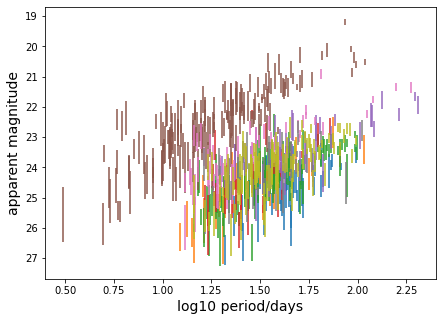

In [9]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
for g in ngc_numbers:
    plt.errorbar(data[g]['logP'], data[g]['m'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 period/days', fontsize=14);
plt.ylabel('apparent magnitude', fontsize=14);
plt.gca().invert_yaxis();

Of course, the _apparent_ magnitude (related to the observed flux) is not a good basis for comparing Cepheid populations in galaxies at different distances from us. We'll want to convert this to the absolute magnitude, an intrinsic property.

Apparent magnitude, $m$, is converted to absolute magnitude, $M$, via the luminosity distance, $d_\mathrm{L}(z)$:

$m = M + 5 \log_{10}\left(\frac{d_\mathrm{L}(z)}{\mathrm{Mpc}}\right) + 25$.

This is the silly astronomer's version of the relationship between flux, luminosity and distance, $F \propto L/d_\mathrm{L}^2$.

The host galaxies in the R11 sample are all very nearby (check the maximum redshift read in above), so let's assume that distance is proportional to redshift $z$ via Hubble's law:

$d_\mathrm{L}(z) = \frac{cz}{H_0}$,

where $c = 3\times10^5 {\rm ~km~s}^{-1}$ and $H_0 = 70 {\rm ~km~s}^{-1} {\rm Mpc}^{-1}$. Note that having these constants correct is not important for accounting for the _relative_ distance to each galaxy, i.e. getting their period-luminosity scatterplots to line up.

Go ahead and add entries for the luminosity distance (scalar) and Cepheid absolute magnitudes (array) to the dictionary for each galaxy.

In [10]:
c = 3.0e5 # km/s
H0 = 70.0 # km/s/Mpc

for g in ngc_numbers:
    data[g]['dL'] = c*data[g]['z']/H0
    data[g]['M'] = data[g]['m']-5*np.log(data[g]['dL'])+25

Note that, since we're assuming a perfectly known, additive translation from $m$ to $M$, `merr` describes the uncertainty either $m$ or $M$.

Let's see whether the Cepheids for each galaxy line up when plotting the absolute magnitudes:

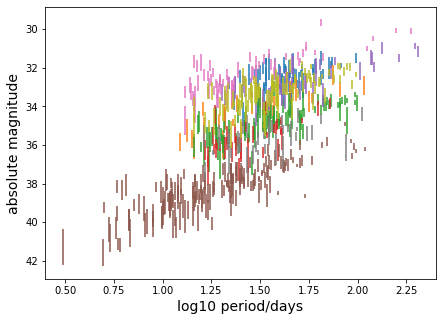

In [11]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
for g in ngc_numbers:
    plt.errorbar(data[g]['logP'], data[g]['M'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 period/days', fontsize=14);
plt.ylabel('absolute magnitude', fontsize=14);
plt.gca().invert_yaxis();

**Checkpoint:** Pretty much! You should see a fairly clear trend.

The data also include `log(O/H)`, a measure of the metallicity of each star. Let's see how that looks vs. the magnitude:

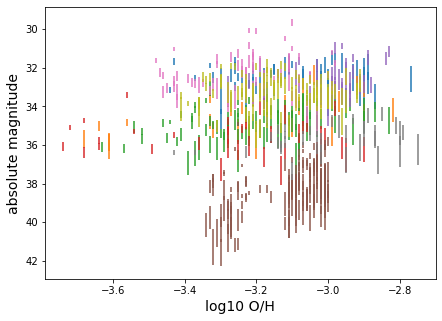

In [12]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
for g in ngc_numbers:
    plt.errorbar(data[g]['logO_H'], data[g]['M'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 O/H', fontsize=14);
plt.ylabel('absolute magnitude', fontsize=14);
plt.gca().invert_yaxis();

We would have to check in the paper whether the metallicity is expected to have an influence on the Cepheid luminosity or period (or, indeed, whether some metallicity-based correction has already been applied). Let's keep things relatively simple for this example by neglecting any of that, and focusing only on the supplied periods and magntitudes.

Similarly, the final column, `bias` is something that has _already_ been applied by R11. If we were specialists we might second guess this, but for our purposes we can leave it alone.

One last thing, which can be seen in the plots above already, is that the distribution of periods is nonuniform, and varies from galaxy to galaxy. Let's look at period histograms for each galaxy, because we can.

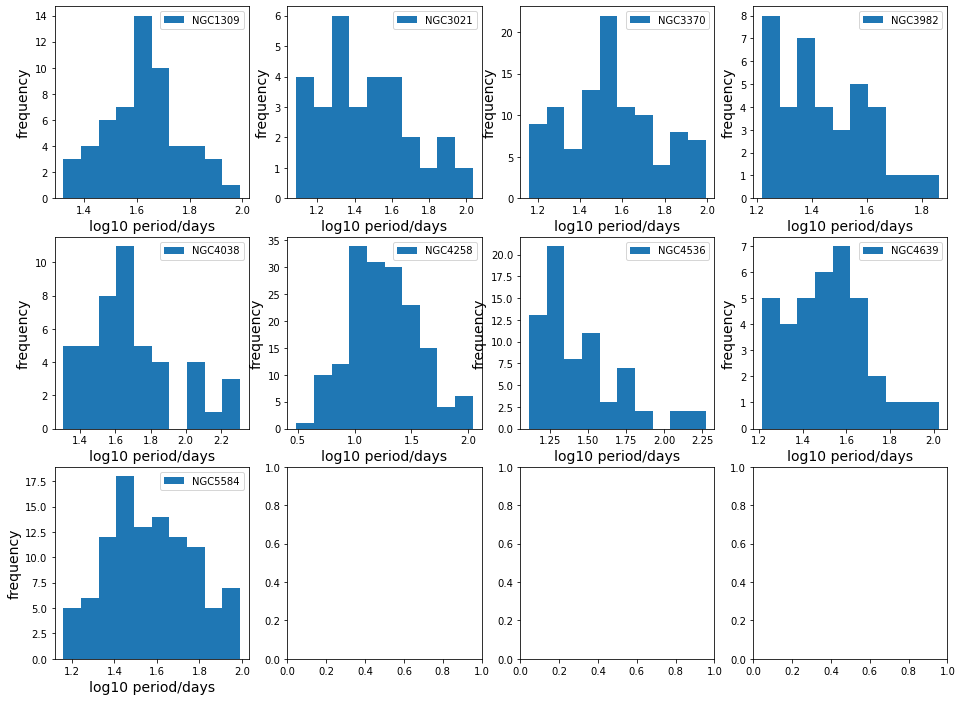

In [13]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(3,4)
for i,g in enumerate(ngc_numbers):
    j = np.unravel_index(i,ax.shape)
    ax[j].hist(data[g]['logP'], label='NGC'+str(g));
    ax[j].set_xlabel('log10 period/days', fontsize=14);
    ax[j].set_ylabel('frequency', fontsize=14);
    ax[j].legend();

The most obvious explanation for this variation is a selection effect due to the frequency with which each galaxy was observed - we can't have measured periods much shorter or longer than the observation cadence with any fidelity.

## Defining a model

It's standard to fit a linear relation between absolute magnitude and log-period, which translates to a power-law between luminosity and period. That looks broadly reasonable, based on the plots above.

Ultimately, we'll be interested in whether the period-luminosity relations of the different galaxies are indeed universal, meaning that exactly the same relationship holds for ech galaxy. So, let's consider that the parameters of those relations may not be identical:

$M = a_i + b_i \log_{10}P$, with $i$ indexing the host galaxies.

However, we wouldn't expect the intercepts and slopes for different galaxies to be entirely unrelated to one another either. This is one aspect that makes the problem hierarchical - there are properties of each galaxy ($a_i$ and $b_i$) that we believe should follow some parent distribution, even if they aren't identical.

Similarly, at a lower level, we've assumed that the Cepheids within each host follow the scaling relation above. However, we should allow for the possibility that they don't follow the relation exactly; there may be some intrinsic scatter that makes the true magnitudes deviate from the linear relation above, even without accounting for measurement errors. This is another level of the hierarchy - there is a property of every Cepheid in a given host ($M$) that follows a parent distribution specific to that host (some to-be-specified scatter distribution about the linear relation above).

As for the measured quantities, for the apparent magnitudes we are given estimates and error bars (as is common). With nothing else to go on, we'd normally assume these are Gaussian uncertainties, and normally this should be accurate enough for background-subtracted fluxes measured from many photons. We are given no information about uncertainty in the periods, so we'll have to assume those are precise. (If they aren't, this might contribute to any intrinsic catter we see.[$^1$](#Note-1)) Similarly, we'll take the redshifts to be precise, as measuring them to high accuracy and precision should be straightforward for such nearby galaxies. The fact that the galaxies are so nearby also means that we don't really need to worry about modeling uncertainties in the conversion from absolute to apparent magnitudes (the linear apparoximation of $d_\mathrm{L}$ above).

To summarize our model:
* We have precise periods and Gaussian distributed apparent magnitudes for a number of Cepheids in different galaxies.
* Each galaxy's redshift is given precisely, allowing us to compute a distance and convert between apparent and absolute magnitude with negligible uncertainty.
* Within a given galaxy, Cepheid magnitudes and log-periods are assumed to follow an overall linear trend, with some intrinsic scatter.
* The parameters of the line and scatter may not be identical from galaxy to galaxy, but we'll assume they are drawn from some to-be-specified parent distributions.

We'll get more specific about what PDFs to use later, but this should be enough to draw a nice, hierarchical PGM for this problem. Do so.

## Finishing up

That's it! On this basis, you can move on to one of the tutorials that use the cepheid data set. Those tutorials don't have to be done in any particular order, and doing one rather than both is fine. If you are planning to do both, however, it probably makes sense to start with the "one galaxy" notebook.

#### Endnotes

##### Note 1

The notion that we could know the periods so precisely while the average luminosities have pretty substantial uncertainties is... suspicious. We don't have an explanation for this.